(6,)
[ 3.23564172e+03  2.69372566e+03 -5.33542794e+03 -4.87430005e+00
  5.89879341e+00  1.97764800e-02]
[ 5.44580049e+01  5.26640993e+03 -4.29410386e+03 -6.08667545e+00
  2.96524074e+00  3.56842861e+00]
[-3.52971809e+03  5.68941619e+03 -1.12738229e+03 -4.60450780e+00
 -1.70536224e+00  5.87906626e+00]
[-5.31789592e+03  3.42717591e+03  2.44415114e+03 -1.01268673e+00
 -5.40547502e+00  5.34377636e+00]
[-4.67186308e+03 -3.98291455e+02  4.89244998e+03  3.04785607e+00
 -6.63599801e+00  2.36115732e+00]
[-1.85233937e+03 -4.06972238e+03  5.08980719e+03  5.73275012e+00
 -4.79701928e+00 -1.74703718e+00]
[ 1.61237481e+03 -5.80831582e+03  3.09937261e+03  5.82521265e+00
 -1.00365351e+00 -4.89215191e+00]
[ 4.50190902e+03 -5.06538757e+03 -3.26473382e+02  3.36924827e+00
  3.36520813e+00 -6.00688659e+00]
[ 5.39077634e+03 -2.24504383e+03 -3.46738945e+03 -3.73823337e-01
  6.13189211e+00 -4.57193814e+00]
[ 3.97936014e+03  1.67983154e+03 -5.24675969e+03 -4.11646813e+00
  6.35816696e+00 -1.09172526e+00]
[ 7.5

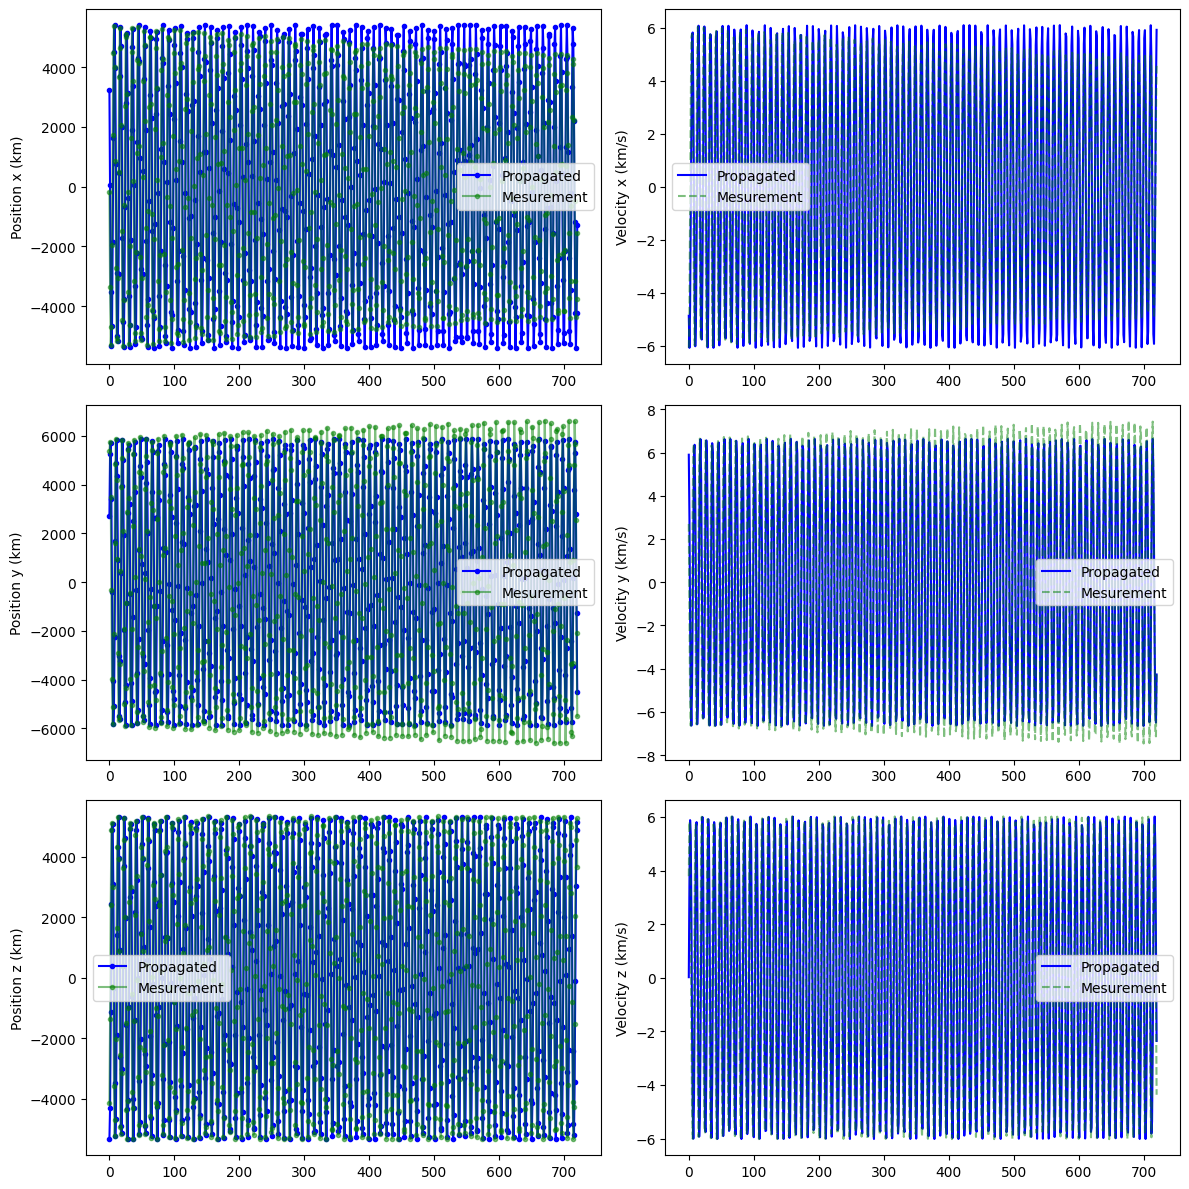

In [2]:
from astropy.time import Time, TimeDelta
from poliastro.twobody import Orbit
from poliastro.bodies import Earth
from astropy import units as u
import numpy as np
import matplotlib.pyplot  as plt

# Load measurement data from file
npzfile = np.load('GPS_meas.npz', allow_pickle=True)
noisy_measurement = npzfile['measurements']
t_measurement = npzfile['t_measurements']
# Convert measurement times to Time objects
t_measurement_time = Time(t_measurement)

N = len(t_measurement) # Number of measurements.

# Calculate time intervals (dt) between consecutive measurements
dt_list = (t_measurement_time[1:] - t_measurement_time[:-1]) # TimeDelta object. Shape: (720,)


# gps measurement data
meas_pos = noisy_measurement[:, 0:3] # measured position. Shape: (N, 3)
meas_vel = noisy_measurement[:, 3:6] # measured velocity. Shape: (N, 3)

# Initial state vector
position = [3235.64171524, 2693.72565982, -5335.42793567] 
velocity = [-4.87430005, 5.89879341, 0.01977648] 
# t_astropy = Time(t_measurement[0]) # Time object
x = np.hstack((position, velocity)) # initial state vector. Shape: (6,)
print(x.shape)
print(x)


states = [x]
for i in range(1, N):
    orbit = Orbit.from_vectors(Earth, x[:3]<< u.km, x[3:]<< u.km / u.s)
    dt = dt_list[i-1].sec
    orbit = orbit.propagate(TimeDelta(dt * u.s))
    x = np.hstack((orbit.r.to(u.km).value, orbit.v.to(u.km / u.s).value))
    print(x)
    states.append(x)


# Plotting the results (3,2) plots, first 3 colrums pos x, y, z, last 3 colrums vel x, y, z
states = np.array(states)   
pos = states[:, :3]
vel = states[:, 3:]

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
for i in range(3):
    axs[i, 0].plot(pos[:, i], 'b.-', alpha=1, label='Propagated')
    axs[i, 0].plot(meas_pos[:, i], 'g.-',alpha=0.5, label='Mesurement')
    axs[i, 0].set_ylabel(f'Position {["x", "y", "z"][i]} (km)')
    axs[i, 0].legend()
    axs[i, 1].plot(vel[:, i], 'b', alpha=1, label='Propagated')
    axs[i, 1].plot(meas_vel[:, i], 'g--',alpha=0.5, label='Mesurement')
    axs[i, 1].set_ylabel(f'Velocity {["x", "y", "z"][i]} (km/s)')
    axs[i, 1].legend()

plt.tight_layout()
plt.show()
